In [1]:
%load_ext autoreload
%autoreload 2
import pointCollection as pc
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import h5py
%matplotlib notebook
from ATL11.RDE import RDE
import scipy.interpolate as si
import os
from ATL11.rtw_mask import rtw_mask_for_delta_time
import scipy.ndimage.morphology as morph
import netCDF4 as nc

data_root='/Volumes/ice2/ben/MAR/ATL11_with_corrections/'
data_sub='/rel002/'
PLOT_MAPS=False

secular_correction='zsurf_mean'
version=data_sub.replace('/','')+'_zsurf'
#secular_correction='smb_mean'
#version='v2_SMB'

model_list=[ 'MARv3.11.2-ERA-6km','MARv3.11.2-ERA-20km',
           'MARv3.11.2-NCEP-20km', 'GSFC-fdm-v1.1']

#model_list=[ 'MARv3.11.2-ERA-6km', 'GSFC-fdm-v1.1' ]



In [2]:
%matplotlib notebook

In [3]:
#masks:
gimp_mask=pc.grid.data().from_geotif(data_root+'/GimpIceMask_1km.tif')
v_mask=pc.grid.data().from_geotif(data_root+'/vel_mask_annual_nmad_lt_20_simplified.tif')
v_mask.z=morph.binary_erosion(v_mask.z, structure=np.ones((3,3)))
drainage_basins=pc.grid.data().from_geotif(data_root+'/drainage_basins.tif')
db_mask=drainage_basins.copy()
db_mask.z=np.isfinite(db_mask.z)
temp=gimp_mask.interp(db_mask.x, db_mask.y, gridded=True)
db_mask.z[np.where(temp<0.5)]=0
temp=v_mask.interp(db_mask.x, db_mask.y, gridded=True)
db_mask.z[np.where(temp<0.5)]=0

temp=np.isfinite(drainage_basins.z).astype(float)-db_mask.z.astype(float)
F_eliminated = np.sum(temp!=0)/np.sum(np.isfinite(drainage_basins.z) & (drainage_basins.z>0))

print(f"Masking removed {100*F_eliminated}% of the ice sheet")

Masking removed 12.444706506954706% of the ice sheet


In [4]:
if PLOT_MAPS:
    fig=plt.figure(1); plt.clf()
    fig.clf(); hax=[]
    hax.append(fig.add_subplot(131))
    gimp_mask.show(ax=hax[0])
    hax[-1].set_title('ice and rock mask')
    hax.append(fig.add_subplot(132, sharex=hax[0], sharey=hax[0]))
    drainage_basins.show(ax=hax[1])
    hax[-1].set_title('drainage basins')
    hax.append(fig.add_subplot(133, sharex=hax[0], sharey=hax[0]))
    v_mask.show(ax=hax[2])
    hax[-1].set_title('velocity variability < 20 m/yr')

In [5]:
if PLOT_MAPS:
    fig=plt.figure(2); plt.clf()
    fig.clf(); hax=[]
    db_mask=drainage_basins.copy()
    db_mask.z=np.isfinite(db_mask.z)
    temp=gimp_mask.interp(db_mask.x, db_mask.y, gridded=True)
    hax.append(fig.add_subplot(131))
    plt.imshow(np.isfinite(drainage_basins.z).astype(float) -(temp<0.5).astype(float), origin='lower')
    db_mask.z[np.where(temp<0.5)]=0
    temp=v_mask.interp(db_mask.x, db_mask.y, gridded=True)
    hax.append(fig.add_subplot(132))
    plt.imshow(np.isfinite(drainage_basins.z).astype(float) -(temp<0.5).astype(float), origin='lower')
    db_mask.z[np.where(temp<0.5)]=0
    hax.append(fig.add_subplot(133))
    plt.imshow(np.isfinite(drainage_basins.z).astype(float)-db_mask.z.astype(float), origin='lower')



In [6]:
def safe_read(fh, group, field):
    temp=np.array(fh[group][field])
    temp[np.abs(temp) > 1.e15] = np.nan
    return temp

In [11]:
xo_file=data_root+data_sub+'/rel002_crossover_data.h5'
#xo_file='/Volumes/ice1/tyler/U07_crossover_data.h5'
with h5py.File(xo_file,'r') as h5f:
    print(list(h5f.keys()))
    print(h5f['x'].shape)
    xo_cols=h5f['x'].shape[1]
xo_cycles=np.arange(xo_cols)

#at_file='/Volumes/ice1/tyler/relU07_dump_every_4th.h5'
at_file=data_root+data_sub+'/rel002_dump_every_2nd.h5'
with h5py.File(at_file,'r') as h5f:
    print(list(h5f.keys()))
    print(h5f['x'].shape)
    at_cols=h5f['x'].shape[1]
at_cycles=np.arange(3, 3+at_cols)

['GSFC-fdm-v1.1', 'MARv3.11.2-ERA-10km', 'MARv3.11.2-ERA-20km', 'MARv3.11.2-ERA-6km', 'MARv3.11.2-NCEP-20km', 'RACMO2.3p2-FGRN055', 'along_track_rss', 'atl06_quality_summary', 'cycle_number', 'dac', 'delta_time', 'dem_h', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'rgt', 'tide_ocean', 'x', 'x_atc', 'y']
(11699328, 8, 2)
['GSFC-fdm-v1.1', 'MARv3.11.2-ERA-10km', 'MARv3.11.2-ERA-20km', 'MARv3.11.2-ERA-6km', 'MARv3.11.2-NCEP-20km', 'RACMO2.3p2-FGRN055', 'cycle_number', 'delta_time', 'dem_h', 'file_ind', 'fit_quality', 'h_corr', 'h_corr_sigma', 'h_corr_sigma_systematic', 'latitude', 'longitude', 'quality_summary', 'ref_pt', 'x', 'x_atc', 'y']
(17504537, 6)


In [12]:
def read_corrections(file, model, D):
    if 'GSFC' in model:
        GSFC=True
        MAR=False
    else:
        GSFC = False
        MAR = True
    
    with h5py.File(file,'r') as h5f:
        print(model)
        model_name=model.replace('.','_').replace('-','_')
        zsurf_name=model_name+'_zsurf'
        D.assign({zsurf_name:safe_read(h5f, model, 'zsurf')})
        FAC_name=model_name+'_z_FAC'
        if MAR:
            D.assign({FAC_name:getattr(D, zsurf_name)-safe_read(h5f, model, 'SMB')/917})
        else:            
            D.assign({FAC_name:getattr(D, zsurf_name)-safe_read(h5f, model, 'zsmb')})
            
        if 'zmelt' in h5f[model]:
            D.assign({model_name+'_zmelt':safe_read(h5f, model,'zmelt')})
        
        for field in [ 'smb_mean', 'zsurf_mean']:
            if field in h5f[model]:
                fieldname=model_name+'_'+field
                D.assign({fieldname:safe_read(h5f, model, field)})
                print(f"{fieldname}:{np.mean(np.isfinite(getattr(D, fieldname)), axis=0)}")
                
        if 'SMB' in h5f[model]:
            # MAR model.  SMB in mmWE
            field='SMB'
            fieldname=model_name+'_SMB'
            D.assign({fieldname:safe_read(h5f, model, 'SMB')/917})
            print(f"{fieldname}:{np.mean(np.isfinite(getattr(D, fieldname)), axis=0)}")
        elif 'zsmb' in h5f[model] and 'GSFC' in model:
            fieldname=model_name+'_SMB'
            D.assign({fieldname:safe_read(h5f, model, 'zsmb')})
            print(f"{model_name}:\n{np.mean(np.isfinite(getattr(D, fieldname)), axis=0)}")
        else:
            print(f'{model}: no SMB')        
        print("\n\n")
    return  

In [13]:
D_xo=pc.data(columns=xo_cols).from_h5(xo_file, field_dict={None:['along_track_rss', 'atl06_quality_summary', \
            'cycle_number','delta_time', 'h_corr', 'h_corr_sigma','fit_quality', \
            'latitude', 'ref_pt', 'rgt','x','y']})
# remove data for which the PS projection gave weird results
bad=np.abs(D_xo.x) > 1.e8
D_xo.x[bad]=np.nan
D_xo.x=np.nanmax(np.nanmax(D_xo.x, axis=1), axis=1)
D_xo.y[bad]=np.nan
D_xo.y=np.nanmax(np.nanmax(D_xo.y, axis=1), axis=1)

In [ ]:
print("READING xover CORRECTIONS")
for model in model_list:
    read_corrections(xo_file, model, D_xo)
print(D_xo)
{field:getattr(D_xo, field).shape for field in D_xo.fields}

READING xover CORRECTIONS
MARv3.11.2-ERA-6km
MARv3_11_2_ERA_6km_smb_mean:[[0.         0.19504565]
 [0.         0.26386131]
 [0.5574945  0.24732446]
 [0.31039663 0.18312975]
 [0.65002409 0.26333042]
 [0.68751829 0.28305959]
 [0.57906796 0.22773282]
 [0.5140891  0.21461335]]
MARv3_11_2_ERA_6km_zsurf_mean:[[0.         0.19504565]
 [0.         0.26386131]
 [0.5574945  0.24732446]
 [0.31039663 0.18312975]
 [0.65002409 0.26333042]
 [0.68751829 0.28305959]
 [0.57906796 0.22773282]
 [0.5140891  0.21461335]]
MARv3_11_2_ERA_6km_SMB:[[0.         0.19504565]
 [0.         0.26386131]
 [0.5574945  0.24732446]
 [0.31039663 0.18312975]
 [0.65002409 0.26333042]
 [0.68751829 0.28305959]
 [0.57906796 0.22773282]
 [0.38036202 0.16115635]]



MARv3.11.2-ERA-20km


In [23]:
D_at=pc.data(columns=at_cols).from_h5(at_file, \
            field_dict={None:['x','y','delta_time','quality_summary','fit_quality','h_corr','h_corr_sigma','dem_h','rgt']})

In [24]:
print("READING ALONG-TRACK CORRECTIONS")
for model in model_list:
    read_corrections(at_file, model, D_at)
#print(D_at)
#{field:getattr(D_at, field).shape for field in D_at.fields}

READING ALONG-TRACK CORRECTIONS
MARv3.11.2-ERA-6km
MARv3_11_2_ERA_6km_smb_mean:[0.61800229 0.35745744 0.71630869 0.76409824 0.63548667 0.57009957]
MARv3_11_2_ERA_6km_zsurf_mean:[0.61800229 0.35745744 0.71630869 0.76409824 0.63548667 0.57009957]
MARv3_11_2_ERA_6km_SMB:[0.61800229 0.35745744 0.71630869 0.76409824 0.63548667 0.42019163]



MARv3.11.2-ERA-20km
MARv3_11_2_ERA_20km_smb_mean:[0.62215796 0.35974171 0.72134424 0.76989446 0.6394184  0.57399867]
MARv3_11_2_ERA_20km_zsurf_mean:[0.62215796 0.35974171 0.72134424 0.76989446 0.6394184  0.57399867]
MARv3_11_2_ERA_20km_SMB:[0.62215796 0.35974171 0.72134424 0.76989446 0.6394184  0.42310082]



MARv3.11.2-NCEP-20km
MARv3_11_2_NCEP_20km_smb_mean:[0.62215796 0.35974171 0.72134424 0.76989446 0.6394184  0.57399867]
MARv3_11_2_NCEP_20km_zsurf_mean:[0.62215796 0.35974171 0.72134424 0.76989446 0.6394184  0.57399867]
MARv3_11_2_NCEP_20km_SMB:[0.62215796 0.35974171 0.72134424 0.76989446 0.6394184  0.42310082]



GSFC-fdm-v1.1
GSFC_fdm_v1_1:
[0.629

In [25]:
D_at.fields
np.sum(np.isfinite(D_at.MARv3_11_2_ERA_6km_zsurf), axis=0)

array([10817844,  6257127, 12538652,  9404424,        0,        0])

In [26]:
SMB_GSFC=pc.grid.data()
with nc.Dataset('/home/ben/git_repos/SMBcorr/gsfc_fdm_v1_gris_SMB_mean_1980_1995.nc','r') as ncf:
    for field in ['x','y','SMB_mean']:
        SMB_GSFC.assign({field:np.array(ncf[field]).T})
        print(f'{field} : {getattr(SMB_GSFC, field).shape}')
SMB_GSFC.SMB_mean[SMB_GSFC.SMB_mean==-9999.]=np.nan
# GSFC SMB_mean grid is in m ice /yr. Need to convert to m water /yr.
SMB_GSFC.SMB_mean *= .917/365.25

x : (441,)
y : (281,)
SMB_mean : (281, 441)


In [27]:
D_xo.index((D_xo.x > drainage_basins.x[0]) & (D_xo.x < drainage_basins.x[-1]) & (D_xo.y > drainage_basins.y[0]) & (D_xo.y < drainage_basins.y[-1]))
D_at.index((D_at.x[:,0] > drainage_basins.x[0]) & (D_at.x[:,0] < drainage_basins.x[-1]) & (D_at.y[:,0] > drainage_basins.y[0]) & (D_at.y[:,0] < drainage_basins.y[-1]))

dbi=si.RegularGridInterpolator((drainage_basins.y, drainage_basins.x), drainage_basins.z, method='nearest')
D_xo.assign({'basin':np.round(dbi.__call__((D_xo.y, D_xo.x))*10)/10})
D_at.assign({'basin':np.round(dbi.__call__((D_at.y[:,0], D_at.x[:,0]))*10)/10});

In [28]:
# mask out non-ice areas
D_at.assign({'ice_mask':np.round(gimp_mask.interp(D_at.x[:,0], D_at.y[:,0])*10)/10});
D_xo.assign({'ice_mask':np.round(gimp_mask.interp(D_xo.x, D_xo.y)*10)/10})

<class 'pointCollection.data.data'> with shape (10356613, 8, 2),
with fields:
['along_track_rss', 'atl06_quality_summary', 'cycle_number', 'delta_time', 'h_corr', 'h_corr_sigma', 'fit_quality', 'latitude', 'ref_pt', 'rgt', 'x', 'y', 'MARv3_11_2_ERA_6km_zsurf', 'MARv3_11_2_ERA_6km_z_FAC', 'MARv3_11_2_ERA_6km_zmelt', 'MARv3_11_2_ERA_6km_smb_mean', 'MARv3_11_2_ERA_6km_zsurf_mean', 'MARv3_11_2_ERA_6km_SMB', 'MARv3_11_2_ERA_20km_zsurf', 'MARv3_11_2_ERA_20km_z_FAC', 'MARv3_11_2_ERA_20km_zmelt', 'MARv3_11_2_ERA_20km_smb_mean', 'MARv3_11_2_ERA_20km_zsurf_mean', 'MARv3_11_2_ERA_20km_SMB', 'MARv3_11_2_NCEP_20km_zsurf', 'MARv3_11_2_NCEP_20km_z_FAC', 'MARv3_11_2_NCEP_20km_zmelt', 'MARv3_11_2_NCEP_20km_smb_mean', 'MARv3_11_2_NCEP_20km_zsurf_mean', 'MARv3_11_2_NCEP_20km_SMB', 'GSFC_fdm_v1_1_zsurf', 'GSFC_fdm_v1_1_z_FAC', 'GSFC_fdm_v1_1_SMB', 'basin', 'ice_mask', 'GSFC_fdm_v1_1_smb_mean', 'vel_mask']

In [29]:
# interpolate out the smb_mean field from GSFC FDM (in polar stereographic)

D_xo.assign({'GSFC_fdm_v1_1_smb_mean':\
             SMB_GSFC.interp(D_xo.x, D_xo.y, field='SMB_mean')})
D_at.assign({'GSFC_fdm_v1_1_smb_mean':\
             SMB_GSFC.interp(D_at.x[:,0], D_at.y[:,0], field='SMB_mean')})

<class 'pointCollection.data.data'> with shape (17474419, 6),
with fields:
['x', 'y', 'delta_time', 'quality_summary', 'fit_quality', 'h_corr', 'h_corr_sigma', 'dem_h', 'rgt', 'MARv3_11_2_ERA_6km_zsurf', 'MARv3_11_2_ERA_6km_z_FAC', 'MARv3_11_2_ERA_6km_zmelt', 'MARv3_11_2_ERA_6km_smb_mean', 'MARv3_11_2_ERA_6km_zsurf_mean', 'MARv3_11_2_ERA_6km_SMB', 'MARv3_11_2_ERA_20km_zsurf', 'MARv3_11_2_ERA_20km_z_FAC', 'MARv3_11_2_ERA_20km_zmelt', 'MARv3_11_2_ERA_20km_smb_mean', 'MARv3_11_2_ERA_20km_zsurf_mean', 'MARv3_11_2_ERA_20km_SMB', 'MARv3_11_2_NCEP_20km_zsurf', 'MARv3_11_2_NCEP_20km_z_FAC', 'MARv3_11_2_NCEP_20km_zmelt', 'MARv3_11_2_NCEP_20km_smb_mean', 'MARv3_11_2_NCEP_20km_zsurf_mean', 'MARv3_11_2_NCEP_20km_SMB', 'GSFC_fdm_v1_1_zsurf', 'GSFC_fdm_v1_1_z_FAC', 'GSFC_fdm_v1_1_SMB', 'basin', 'ice_mask', 'GSFC_fdm_v1_1_smb_mean']

In [30]:
# mask based on the speed variability
D_at.assign({'vel_mask':np.round(v_mask.interp(D_at.x[:,0], D_at.y[:,0])*10)/10});
D_xo.assign({'vel_mask':np.round(v_mask.interp(D_xo.x, D_xo.y)*10)/10});

In [33]:
# filter bad dh values from D_at
bad=(np.abs(D_at.h_corr-D_at.dem_h)>100) | np.tile(np.abs(D_at.ice_mask[:, None]-1)>0.01, [1, at_cols]) 
#bad |= np.tile(np.abs(D_at.vel_mask[:, None]-1)>0.01, [1, at_cols]) 
bad |= np.tile(~np.isfinite(D_at.basin[:, None]), [1,at_cols])
bad |= D_at.fit_quality > 0
bad |= rtw_mask_for_delta_time(D_at.delta_time, csv_file='/home/ben/git_repos/ATL11/ICESat-2_TechRefTable_08282020_RTWs.csv')==0
print('filtering'+str(np.mean(bad)))
D_at.h_corr[bad]=np.nan

filtering0.40248659101818113


In [34]:
# filter bad dh values from D_xo
bad= np.tile(np.abs(D_xo.ice_mask[:, None]-1)>0.01, [1, xo_cols]) 
#bad |= np.tile(np.abs(D_xo.vel_mask[:, None]-1)>0.01, [1, xo_cols]) 
bad |= np.tile(~np.isfinite(D_xo.basin[:, None]), [1, xo_cols])
bad |= np.any(D_xo.atl06_quality_summary==1, axis=2)
bad |= np.any(D_xo.fit_quality>0, axis=2)
bad |= np.any(rtw_mask_for_delta_time(D_xo.delta_time, csv_file='/home/ben/git_repos/ATL11/ICESat-2_TechRefTable_08282020_RTWs.csv')==0, axis=2)
print('editing '+str(np.mean(bad)))
temp=D_xo.h_corr.copy()
temp[:,:,0][bad]=np.nan
temp[:,:,1][bad]=np.nan
D_xo.h_corr=temp
#np.mean(bad[np.isfinite(D_xo.h_corr)])
#D_xo.h_corr[bad]=np.nan

editing 0.4211586717588076


In [35]:
# derive the melt for GSFC from MAR:
D_xo.GSFC_fdm_v1_1_zmelt = D_xo.MARv3_11_2_ERA_6km_zmelt
D_at.GSFC_fdm_v1_1_zmelt = D_at.MARv3_11_2_ERA_6km_zmelt
print(np.mean(np.isfinite(D_xo.MARv3_11_2_ERA_6km_zmelt)))

0.23639430912403506


In [36]:
def reduce_data(D, epoch_slices, model, d_delta_t, block_scale, SMB_mean_field):
    out={}
    for epoch, slices in epoch_slices.items():
        s0, s1=slices
        dh=pc.data()
        dh.assign({'h0':0.5*(D.h_corr[s1]+D.h_corr[s0]),
                   'data':(D.h_corr[s1]-D.h_corr[s0]),
                   'basin':D.basin.copy()})                          
        if len(D.x.shape) > 1:
            dh.assign({'x':D.x[:,0].copy(),\
                'y':D.y[:,0].copy()})
        else:
            dh.assign({'x':D.x.copy(),\
                'y':D.y.copy()})
        for in_field, out_field in {'zsurf':'model', 'zmelt':'z_melt', 'z_FAC':'fac', 'SMB':'smb'}.items():
            temp=getattr(D, model+'_'+in_field)
            dh.assign({out_field:temp[s1]-temp[s0]})
        dh.assign({'sigma':np.sqrt(D.h_corr_sigma[s1]**2 +D.h_corr_sigma[s0]**2)})
        smb_mean_field=model+'_'+secular_correction
        if 'GSFC' not in model:
            if smb_mean_field not in D.fields:
                #if 'NCEP' in model:
                #    smb_mean_field = 'MARv3_11_2_NCEP_20km_zsurf'
                #else:
                #    smb_mean_field = 'MARv3_11_2_ERA_10km_zsurf'
                print(f'MISSING: {smb_mean_field}')
            # both SMB and zsurf_mean are in [something]days^-1
            dt_data = (D.delta_time[s1]-D.delta_time[s0])/24/3600
            if SMB_mean_field == 'smb_mean':
                # smb is in MMWE/day -> divide by rho_ice
                dh.assign({'mean': dt_data * getattr(D, model+'_'+SMB_mean_field)[s0]/917})
            elif SMB_mean_field == 'zsurf_mean':
                # ZN6 (zsurf) is in m/day
                dh.assign({'mean': dt_data * getattr(D, model+'_'+SMB_mean_field)[s0]})
            dh.model -= dh.mean            
            dh.smb -= dh.mean

            print(f'data valid: {np.mean(np.isfinite(dh.data))}, mean valid: {np.mean(np.isfinite(dh.mean))}')
        else:
            #GSFC is already corrected (calculate the mean field but don't apply it)
            dt_data = (D.delta_time[s1]-D.delta_time[s0])/24/3600
            dh.assign({'mean': dt_data * D.GSFC_fdm_v1_1_smb_mean})
            #dh.assign({'mean':np.zeros_like(dh.model)})

        dh.assign({'corrected': dh.data-dh.model})
        dh.assign({'t0':D.delta_time[s0], 't1':D.delta_time[s1], 'vel_mask':D.vel_mask})

        good=np.isfinite(dh.corrected)
        dh.index(good)

        # blockmedian in short-time increments:
        t_bin=np.round(dh.t0/d_delta_t)
        ut_bin=np.unique(t_bin[np.isfinite(t_bin)])
        ii=[]
        for ti in ut_bin:
            these=np.flatnonzero(t_bin==ti)
            bm_ind, count = pc.pt_blockmedian(dh.x[these], dh.y[these], dh.corrected[these], block_scale, index_and_count_only=True)
            if np.any(count > 4):
                bm_ind=bm_ind[count>4,:]
                ii += [np.c_[these[bm_ind[:,0]], these[bm_ind[:,1]]]]
        ii=np.concatenate(ii, axis=0)
        for field in ['x','y', 'data','model','mean','z_melt','corrected','h0','fac','smb', 'basin', 't0', 't1','vel_mask','sigma']:
            temp=getattr(dh, field)
            setattr(dh, field, 0.5*(temp[ii[:,0]]+temp[ii[:,1]]))        
        out[epoch]=dh
    return out

In [37]:
d_delta_t = 10*24*3600
block_scale=2500

In [38]:
epoch_slices = {'2018.Q4-2019.Q2':[np.s_[:,0,1],\
                                   np.s_[:, 2, 0]],
                '2019.Q1-2019.Q2':[np.s_[:,1,1],\
                                   np.s_[:, 2, 0]]}
delta_data={}
for model in model_list:
    model=model.replace('.','_').replace('-','_')
    print(model)
    delta_data[model]=reduce_data(D_xo, epoch_slices, model, d_delta_t, block_scale, secular_correction)

MARv3_11_2_ERA_6km
data valid: 0.07724204814836665, mean valid: 0.14189919040134066
data valid: 0.10152064193187484, mean valid: 0.1894377051648063
MARv3_11_2_ERA_20km
data valid: 0.07724204814836665, mean valid: 0.14330988326009672
data valid: 0.10152064193187484, mean valid: 0.19076729042593366
MARv3_11_2_NCEP_20km
data valid: 0.07724204814836665, mean valid: 0.14330988326009672
data valid: 0.10152064193187484, mean valid: 0.19076729042593366
GSFC_fdm_v1_1


In [39]:
#CHECK GSFC MEAN FIELD HERE!!!
print(f"std of MAR 6km mean field: {np.nanstd(delta_data['MARv3_11_2_ERA_6km']['2018.Q4-2019.Q2'].mean)}")
print(f"std of GSFC  mean field: {np.nanstd(delta_data['GSFC_fdm_v1_1']['2018.Q4-2019.Q2'].mean)}")
print(f"std of MAR 6km smb field: {np.nanstd(delta_data['MARv3_11_2_ERA_6km']['2018.Q4-2019.Q2'].smb)}")
print(f"std of GSFC smb field: {np.nanstd(delta_data['GSFC_fdm_v1_1']['2018.Q4-2019.Q2'].smb)}")
print(f"std of MAR 6km fac field: {np.nanstd(delta_data['MARv3_11_2_ERA_6km']['2018.Q4-2019.Q2'].fac)}")
print(f"std of GSFC fac field: {np.nanstd(delta_data['GSFC_fdm_v1_1']['2018.Q4-2019.Q2'].fac)}")
    

std of MAR 6km mean field: 0.22709381628319794
std of GSFC  mean field: 0.1446882642866097
std of MAR 6km smb field: 0.18574586432422407
std of GSFC smb field: 0.136128499231359
std of MAR 6km fac field: 0.16978515826622376
std of GSFC fac field: 0.12835511950192247


In [40]:
epoch_slices = {'2019.Q2-2019.Q3':[np.s_[:,0], np.s_[:,1]], \
                '2019.Q3-2019.Q4':[np.s_[:,1], np.s_[:,2]], \
                '2019.Q4-2020.Q1':[np.s_[:,2], np.s_[:,3]]}
for model in model_list:
    model=model.replace('.','_').replace('-','_')
    print(model)
    delta_data[model].update(reduce_data(D_at, epoch_slices, model, d_delta_t, block_scale, secular_correction))

MARv3_11_2_ERA_6km
data valid: 0.14949126491701956, mean valid: 0.23034671424554945
data valid: 0.17454354276385384, mean valid: 0.27010145516139905
data valid: 0.364467396598422, mean valid: 0.5732680439904755
MARv3_11_2_ERA_20km
data valid: 0.14949126491701956, mean valid: 0.23147384757112668
data valid: 0.17454354276385384, mean valid: 0.27182460258049207
data valid: 0.364467396598422, mean valid: 0.5775117330081189
MARv3_11_2_NCEP_20km
data valid: 0.14949126491701956, mean valid: 0.23147384757112668
data valid: 0.17454354276385384, mean valid: 0.27182460258049207
data valid: 0.364467396598422, mean valid: 0.5775117330081189
GSFC_fdm_v1_1


In [41]:
#CHECK GSFC MEAN FIELD HERE!!!
epoch='2019.Q3-2019.Q4'
print(f"std of MAR 6km mean field: {np.nanstd(delta_data['MARv3_11_2_ERA_6km'][epoch].mean)}")
print(f"std of GSFC  mean field: {np.nanstd(delta_data['GSFC_fdm_v1_1'][epoch].mean)}")
print(f"std of MAR 6km smb field: {np.nanstd(delta_data['MARv3_11_2_ERA_6km'][epoch].smb)}")
print(f"std of GSFC smb field: {np.nanstd(delta_data['GSFC_fdm_v1_1'][epoch].smb)}")
print(f"std of MAR 6km fac field: {np.nanstd(delta_data['MARv3_11_2_ERA_6km'][epoch].fac)}")
print(f"std of GSFC fac field: {np.nanstd(delta_data['GSFC_fdm_v1_1'][epoch].fac)}")
    

std of MAR 6km mean field: 0.14638902619465502
std of GSFC  mean field: 0.09330716803318254
std of MAR 6km smb field: 0.12679760997253933
std of GSFC smb field: 0.0924016853903986
std of MAR 6km fac field: 0.2015164280418609
std of GSFC fac field: 0.1592232266355549


<IPython.core.display.Javascript object>


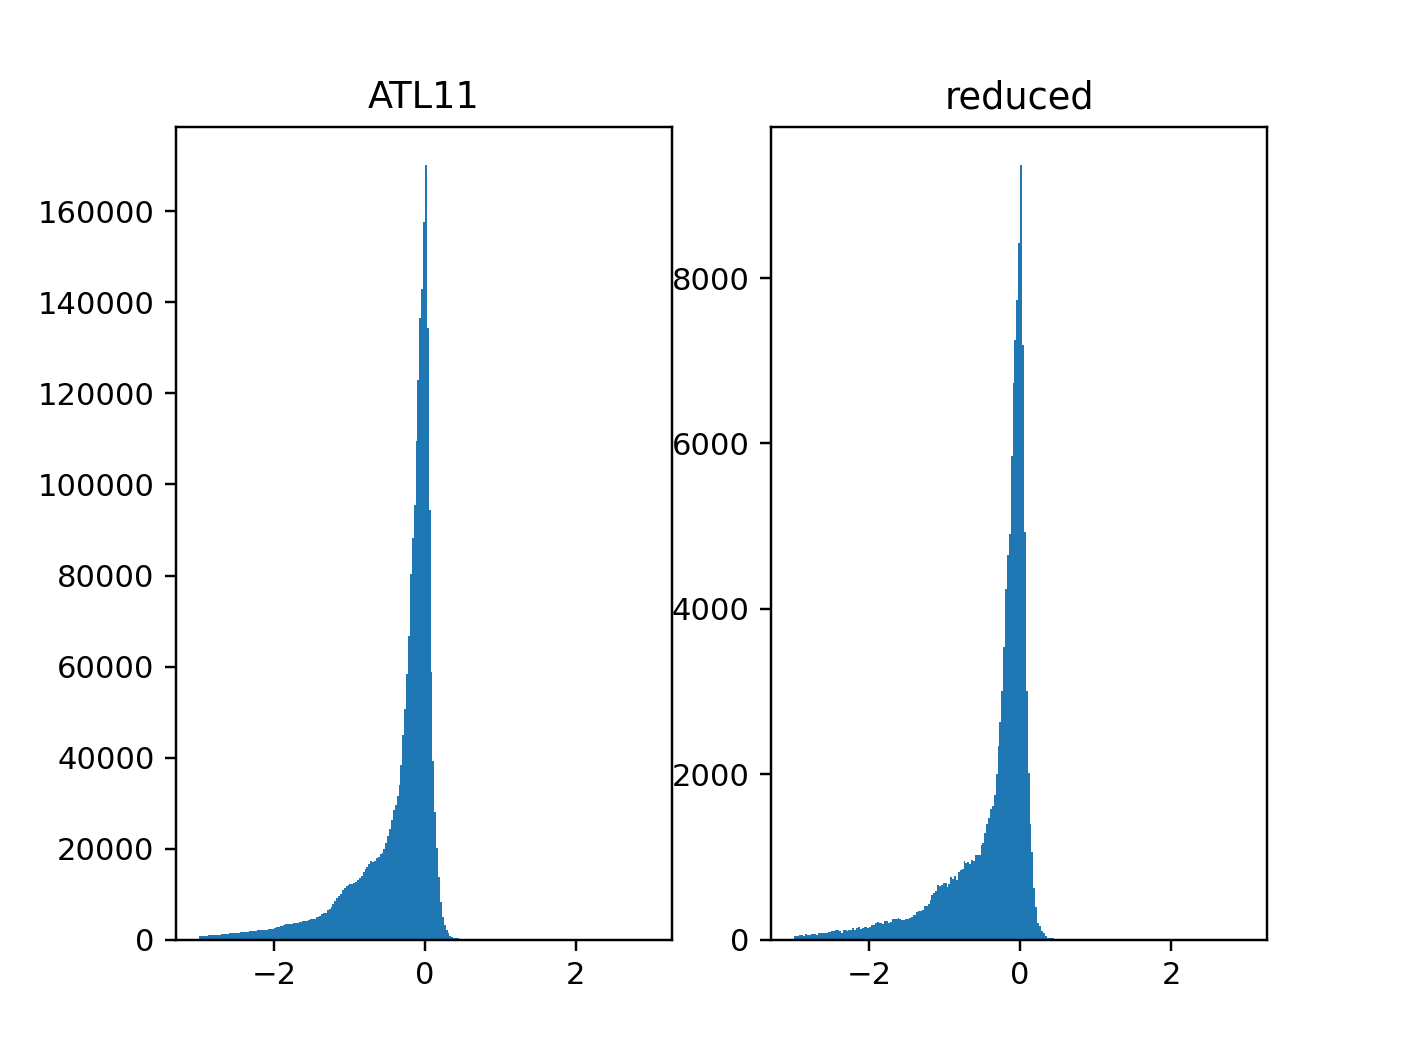

Text(0.5, 1.0, 'reduced')

In [42]:
# make sure the digested data look enough like the raw data

this_model=model_list[0].replace('.','_').replace('-','_')
fig=plt.figure()
fig.add_subplot(121)
plt.hist(D_at.h_corr[:,1]-D_at.h_corr[:,0], np.arange(-3, 3, 0.025))
plt.title('ATL11')
fig.add_subplot(122)
plt.hist(delta_data[this_model]['2019.Q2-2019.Q3'].data, np.arange(-3, 3, 0.025))
plt.title('reduced')

In [43]:
xover_epochs=['2018.Q4-2019.Q2', '2019.Q1-2019.Q2']


In [ ]:
# pull out the cycle-3 corrections
epoch_slices = {'2019.Q2-2019.Q3':[np.s_[:,0], np.s_[:,1]], \
                '2019.Q2-2019.Q4':[np.s_[:,0], np.s_[:,2]], \
                '2019.Q2-2020.Q1':[np.s_[:,0], np.s_[:,3]]}
xover_epochs=['2018.Q4-2019.Q2', '2019.Q1-2019.Q2']
# these are the same for the crossover cycles
delta_data_c3={}
for model in delta_data.keys():
    delta_data_c3[model]={}
    for epoch in xover_epochs:
        delta_data_c3[model][epoch] = delta_data[model][epoch].copy()

for model in model_list:
    model=model.replace('.','_').replace('-','_')
    print(model)
    delta_data_c3[model].update(reduce_data(D_at, epoch_slices, model, d_delta_t, block_scale, secular_correction))

### Plot each epoch

In [ ]:
fig=plt.figure( figsize=[8, 6])
ax=fig.subplots(3, 5, gridspec_kw={'wspace':0.05, 'hspace':0.05})#, sharex=True, sharey=True)
strings=xover_epochs+['2019.Q2-2019.Q3', '2019.Q3-2019.Q4', '2019.Q4-2020.Q1']

for row, model in enumerate(['Data',  'MARv3_11_2_ERA_6km', 'GSFC_fdm_v1_1']):
    for col, epoch in enumerate(strings):
        if row==0:
            ax[row, col].set_title(epoch.replace('-','\n to '))
        if col==0:
            ax[row, col].set_ylabel(model)
        if model == 'Data':
            D=delta_data['MARv3_11_2_ERA_6km']
            temp=D[epoch]
            dh=temp.data
        else:
            D=delta_data[model]
            temp=D[epoch]            
            dh=D[epoch].corrected   
        ind=np.argsort(np.abs(dh))    
        hi=ax[row, col].scatter(temp.x[ind], temp.y[ind], 1, c=dh[ind],\
                 vmin=-2.5, vmax=2.5, cmap='Spectral');
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        plt.axis('equal');
plt.colorbar(hi, ax=ax, shrink=0.5, extend='both', label='$\delta h$, m');

In [44]:
out_file=data_root+f'/combined_xover_at_differences_{version}.h5'
if os.path.isfile(out_file):
    os.remove(out_file)
for model in delta_data.keys():
    for epoch in delta_data[model]:
        delta_data[model][epoch].to_h5(out_file, group='/'+model+'/'+epoch, replace=False)

In [ ]:

fig=plt.figure(22, figsize=[8, 6])
ax=fig.subplots(3, 5, gridspec_kw={'wspace':0.05, 'hspace':0.05})
strings=xover_epochs+['2019.Q2-2019.Q3', '2019.Q2-2019.Q4', '2019.Q2-2020.Q1']

for row, model in enumerate(['Data',  'MARv3_11_2_ERA_6km', 'GSFC_fdm_v1_1']):
    for col, epoch in enumerate(strings):
        if row==0:
            ax[row, col].set_title(epoch.replace('-','\n to '))
        if col==0:
            ax[row, col].set_ylabel(model.replace('_zsurf','').replace('_6km',''))
        if model == 'Data':
            D=delta_data_c3['MARv3_11_2_ERA_6km']
            temp=D[epoch]
            dh=temp.data
        else:
            D=delta_data_c3[model]
            temp=D[epoch]            
            dh=D[epoch].corrected     
        ind=np.argsort(np.abs(dh))    
        hi=ax[row, col].scatter(temp.x[ind], temp.y[ind], 1, c=dh[ind],\
                 vmin=-2.5, vmax=2.5, cmap='Spectral');
        ax[row, col].set_xticks([])
        ax[row, col].set_yticks([])
        plt.axis('equal');
plt.colorbar(hi, ax=ax, shrink=0.5, extend='both', label='$\delta h$, m');



In [ ]:
out_file=data_root+f'/combined_xover_at_differences_wrtc3_{version}.h5'
if os.path.isfile(out_file):
    os.remove(out_file)
for model in delta_data_c3.keys():
    for epoch in delta_data_c3[model]:
        delta_data_c3[model][epoch].to_h5(out_file, group='/'+model+'/'+epoch, replace=False)

In [ ]:
! ls -lt /Volumes/ice2/ben/MAR/ATL11_with_corrections//combined_xover_at_differences_*


In [ ]:
! ls -l {out_file}

In [ ]:
fig=plt.figure( figsize=[8, 2])
ax=fig.subplots(1, 5, gridspec_kw={'wspace':0.05, 'hspace':0.05})#, sharex=True, sharey=True)
strings=xover_epochs+['2019.Q2-2019.Q3', '2019.Q3-2019.Q4', '2019.Q4-2020.Q1']


for col, epoch in enumerate(strings):
    ax[ col].set_title(epoch.replace('-','\n to '))
   
    temp=delta_data['MARv3_11_2_ERA_6km'][epoch]
    dh=temp.melt
        
    ind=np.argsort(np.abs(dh))    
    hi=ax[col].scatter(temp.x[ind], temp.y[ind], 1, c=dh[ind],\
                 vmin=-2.5, vmax=2.5, cmap='Spectral');
    ax[row, col].set_xticks([])
    ax[row, col].set_yticks([])
    plt.axis('equal');
plt.colorbar(hi, ax=ax, shrink=0.5, extend='both', label='$\delta h$, m');